# 成功的提示工程

---

在之前的章节中，我们已经构建了具备记忆功能的聊天机器人，并通过 RAG 将其连接到真实世界的数据，还利用**系统提示**将其调校为专业的 AI 助手。现在，是时候拓展我们对提示的认知了——提示并不仅仅是系统提示和用户查询。在一套 LLM 应用中，我们需要组合多种提示类型，引导模型输出符合预期的结果。

虽然**系统提示**定义了 LLM 的人格，但仍然存在许多关键问题等待解答：

* RAG 增强的 LLM 如何理解并使用从知识库检索到的上下文？
* 如何精调提示以获得最大的成效？

## 故事进展

用户非常喜欢 **TaskFriend**！不过，最近他们发现输出存在不一致的问题：**TaskFriend** 有时会跑题，或采用与预期不符的格式。简而言之——**TaskFriend** 缺乏明确的响应规范。

## 学习目标

* 理解提示模板如何引导 LLM 在 RAG 系统中使用检索到的上下文
* 学会运用 Role-Goal-Context-Audience-Format-Guardrails 框架设计高效的系统提示
* 掌握高级提示工程技巧：角色/人设提示、少样本学习、链式思维
* 使用元提示（Meta Prompting）自动改进提示
* 利用“LLM 作为裁判”技术，实现自动化评估与打分

## 初始化环境

### 配置 API Key

在任何笔记本开始工作前，我们都需要加载 [Model Studio 的 API Key](https://modelstudio.console.alibabacloud.com/?tab=globalset#/efm/api_key)，以便调用本课程中会持续使用的 Qwen 模型接口。

> 若不清楚如何获取 **Model Studio** API Key，请参考 `00 Setting Up the Environment` 文件。

In [1]:
# Load Model Studio API key
import os
from config.load_key import load_key
load_key(
    confirmation=False
)

Detected existing API key: sk-8...2716
Auto-confirmation enabled. Using existing API key.


### 配置 LLM 与嵌入模型

我们将使用阿里云的 `qwen-plus` 作为 LLM，并搭配 DashScope 的 `text-embedding-v3` 作为嵌入模型。

本章节将把前面使用的 `OpenAI` 客户端替换为 `OpenAILike`。该客户端是 **LlamaIndex 专用封装**，适用于以下兼容 OpenAI 协议的模型：

* Model Studio
* DashScope
* vLLM
* Ollama
* 具备 OpenAI 兼容接口的本地 LLM

> **提示：** DashScope 的 API 端点为 `https://dashscope-intl.aliyuncs.com/api/v1`，不同于我们此前使用的 `https://dashscope-intl.aliyuncs.com/compatible-mode/v1`。

In [2]:
# Set global settings
import time
import logging
import dashscope
from llama_index.core import Settings, VectorStoreIndex, SimpleDirectoryReader
from llama_index.embeddings.dashscope import DashScopeEmbedding
from llama_index.llms.openai_like import OpenAILike
from pathlib import Path

logging.getLogger().setLevel(logging.ERROR)

# DashScope domestic endpoint
dashscope.base_http_api_url = "https://dashscope.aliyuncs.com/api/v1"

Settings.llm = OpenAILike(
    model="qwen-plus",
    api_base="https://dashscope.aliyuncs.com/compatible-mode/v1",
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    is_chat_model=True
)

Settings.embed_model = DashScopeEmbedding(
    model_name="text-embedding-v3",
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    encoding_format="float"
)

print("✅ Global parameters set!")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/chengzh/.venv/lib/python3.12/site-
[nltk_data]     packages/llama_index/core/_static/nltk_cache...
[nltk_data]   Package punkt_tab is already up-to-date!


✅ Global parameters set!


### 加载索引并启用 RAG

由于我们在前一章已经构建并保存了索引，此处只需从保存位置（`./knowledge_base/taskfriend`）加载即可。

我们将使用 `llama_index` 提供的以下组件：

* `StorageContext`：负责存储此前保存的节点、嵌入向量以及向量库，便于代码连接现有数据，从而无需重新处理文档即可恢复整个知识库。
* `load_index_from_storage`：基于 `StorageContext` 中的文件重建 RAG 索引，是快速恢复 RAG 系统的高效方法。

In [3]:
from llama_index.core import StorageContext, load_index_from_storage

persist_path="./knowledge_base/taskfriend"

# Import index ("knowledgebase") we built last chapter,
storage_context = StorageContext.from_defaults(
    persist_dir=persist_path,
)

index = load_index_from_storage(
    storage_context,
    embed_model=Settings.embed_model
)
print(f"✅ Index loaded from `{persist_path}`!")

# Build the query engine (used to implement RAG)
query_engine = index.as_query_engine(
    streaming=True,
    llm=Settings.llm,
)
print("✅ Query engine built!")

✅ Index loaded from `./knowledge_base/taskfriend`!
✅ Query engine built!


我们已在上一章配置了 `get_qwen_stream_response` 函数，因此此处直接复用即可。

In [4]:
from llama_index.core import PromptTemplate
from IPython.display import Markdown, display

def update_prompt_template(
        query_engine,
        # Use LlamaIndex prompt template as default template
        prompt_tmpl_str = (
            "Context information is below.\n"
            "---------------------\n"
            "{context_str}\n"
            "---------------------\n"
            "Given the context information and not prior knowledge, "
            "answer the query.\n"
            "Query: {query_str}\n"
            "Answer: "
    )):
    prompt_tmpl_str = prompt_tmpl_str
    qa_prompt_tmpl = PromptTemplate(prompt_tmpl_str)
    query_engine.update_prompts(
        {"response_synthesizer:text_qa_template": qa_prompt_tmpl}
    )
    return query_engine

def ask_llm(query, query_engine):
    streaming_response = query_engine.query(query)
    
    full_response = ""
    for token in streaming_response.response_gen:
        print(token, end="", flush=True)
        full_response += token

# 提示基础：如何构造优质提示

---

## 强力系统提示的组成（回顾）

在之前的章节中，我们已经了解到，**系统提示** 就是 AI 的**岗位说明书**。缺乏清晰指令时，模型往往会自由发挥，并产生不尽如人意的表现。

正如您不会对新入职的助理说“随便和团队打成一片”那样，我们也不应只对 AI 说“请帮忙”。

更好的做法是明确地定义：

```mermaid
graph TD
SP[System Prompt]
SP --> R[Role <br><em>You are TaskFriend...</em>]
SP --> G[Goal <br><em>Help users manage tasks</em>]
SP --> C[Context<br><em>What information is available</em>]
SP --> A[Audience<br><em>Users are professionals</em>]
SP --> F[Format <br><em>Use bullet points</em>]
SP --> GR[Guardrails <br><em>Never roleplay</em>]
```

在撰写**系统提示**时，清晰与精准至关重要。上述框架为设计系统提示提供了一个**蓝图**，帮助我们构建既可靠又聚焦任务的提示。

| 元素 | 作用 | 示例 |
|--------|---------|---------|
| **Role** | 定义 AI 的身份与人设，决定交互语气。 | `你是 TaskFriend，一名专注工作效率与生活平衡的专业 AI 助手。` |
| **Goal** | 明确优先完成的任务，确保模型聚焦。 | `帮助用户规划、优先排序并复盘日常任务，以提升生产力与幸福感。` |
| **Context** | 指出可访问的背景信息或数据范围。 | `你可以通过 RAG 访问用户的任务列表、日程安排与个人笔记。` |
| **Audience** | 明确目标用户群，调整语言深度与风格。 | `你的用户是忙碌的职场人士，他们重视清晰、高效和可执行的建议。` |
| **Format** | 规范输出结构和风格，提升可用性。 | `使用中性、专业的语言；在合适时输出结构化建议（例如项目符号）。` |
| **Guardrails** | 设定安全边界，防止出现不当或跑题内容。 | `绝不要模仿口音、扮演其他角色或进行角色扮演；如被要求，请礼貌拒绝。` |

由于我们已在前文详述 **系统提示**，此处不再赘述。本章将把重点转向 RAG 系统中的**提示模板**。

## 提示模板：让上下文与查询协同工作

在 RAG 系统中，提示模板负责告诉 LLM：如何利用检索到的上下文信息生成回答。

可以这样理解：

* **系统提示** 决定 AI “是谁”。
* **提示模板** 决定 AI “如何使用”信息回答问题。

提示模板在 RAG 中尤为关键，因为它们能够：

* 确保模型使用的是检索上下文，而非既有知识
* 指导模型如何在上下文基础上推理
* 定义最终回答的格式与结构

LlamaIndex 默认提供了如下 RAG 提示模板：

```python
"Context information is below.\n"
"---------------------\n"
"{context_str}\n"
"---------------------\n"
"Given the context information and not prior knowledge, "
"answer the query.\n"
"Query: {query_str}\n"
"Answer: "
```

其中：

* `{context_str}`：从 RAG 索引检索到的**上下文信息**（如任务列表、日程信息等）
* `{query_str}`：用户的**输入问题**

注意：这不是系统提示，而是每次查询时用来指导 LLM 解读上下文的模板。

> 想了解 LlamaIndex 提供的更多提示模板，请参考：
> * [Prompts](https://docs.llamaindex.ai/en/stable/module_guides/models/prompts/)（提示模板概览）
> * [default prompts](https://github.com/run-llama/llama_index/blob/main/llama-index-core/llama_index/core/prompts/default_prompts.py)（默认模板源码）

## 系统提示与提示模板的区别

| 特性  | 系统提示  | 提示模板  |
|----------|----------------|------------------|
| 使用时机 | 对话开始时 | 每次问答时 |
| 作用 | 定义 AI 的身份、语气与边界 | 指导模型如何结合上下文回答问题 |
| 作用范围 | 贯穿整个会话 | 针对每次查询 |
| 示例 | “你是 TaskFriend，一位生产力助手。” | “基于以下上下文回答问题。” |

* **系统提示** 关注 “AI 是谁”
* **提示模板** 关注 “AI 如何回答”

# 进阶：打造更聪明的提示模板

---

## 清晰表达需求

LLM 在预训练时接触过大量格式化的文本，这对我们来说是好消息：我们可以编写既方便人类阅读、又能让模型精准理解的提示。

以下是一些提升模板可读性的排版建议：

* 使用 `# 标题` 标注章节：
```markdown
# Important Instructions
```

* 使用分隔线（`---`）隔开上下文与查询：
```markdown
-------------------------
```

* 使用 \<标签> 或 [括号] 添加元数据：
```markdown
[Context Source: Task List]
<tag>Metadata</tag>
```

* 用 **粗体** 或 *斜体* 突出关键指令：
```markdown
**Do not use prior knowledge.** Only use the *context above*.
```

这些格式有助于人类与模型准确理解提示结构与意图。

接下来，我们为 **TaskFriend** 创建一个结构化的提示模板，以提升输出的清晰度与格式统一性：

In [5]:
prompt_template = (
    "[Instructions] \n"
    "1. Do not make up tasks. \n"
    "2. You must emojis for each piece of information. \n"
    "3. Present information line-by-line. \n"
    "4. Only use information in the context to reply to user queries. \n"
    "5. Please respond in Chinese. \n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Query: {query_str}\n。"
    "Answer: "
)

update_prompt_template(query_engine,prompt_template)

In [6]:
query = """
    Give me a random task from my task list.
"""
ask_llm(query,query_engine)

📅 05 更新凤凰项目路线图  
📌 一次性任务  
⏰ 今天  
📊 状态：待处理  
📝 同步项目负责人，反映最新的时间线、里程碑和资源分配，同时考虑供应链中断的最新变化。

可以看到，**TaskFriend** 能严格遵循我们设定的格式要求。**提示模板** 的强大之处在于，它能在 RAG 系统中承担多种职责，灵活引导输出。

## 局限性

不过你会注意到，提示模板对于与上下文无关的指令并不十分“强势”。

试试看：

In [7]:
query = """
    Give me a random task from my task list.
    Do not use emojis.
    Please respond in Chinese.
"""
ask_llm(query,query_engine)

写一封感谢信给在韩国的笔友，感谢他们在你计划去挪威旅行时提供的帮助，并询问他们新生的儿子埃德温的情况。

In [8]:
query = """
    Give me a task not from my task list.
    Do not use emojis.
    Please respond in Chinese.
"""
ask_llm(query,query_engine)

根据提供的信息，无法提供不在任务列表中的任务。

用户在查询中写下的任何指令，模型都会尽量遵从——哪怕会覆盖我们在模板中设定的部分规则。

不过，只要涉及上下文内容，你会发现提示模板仍能发挥作用。

## 为什么仍要使用提示模板？

### 它们是开发者工具，而非防火墙

提示模板的目标并非阻止用户或强制执行行为，而是为了：

* 标准化传递给 LLM 的输入
* 提升输出的一致性
* 让提示工程更易复用与测试

### 它们能提升 RAG 回答质量

在 RAG 系统中，提示模板是教会模型“如何使用上下文”的关键。

若没有优秀的模板，模型可能会：

* 忽视上下文
* 退回到自身训练知识
* 给出含糊或泛泛的答案

而设计良好的模板能够确保模型确实利用了检索到的知识。

### 它们能强化结构化输出

通过提示模板，我们可以引导模型输出：

* JSON
* 要点列表
* 表格
* 代码
* Markdown

这样有助于下游应用解析与调度模型输出。更棒的是，这类结构化约束在提示模板中非常可靠：

In [9]:
prompt_template = (
    "[Instructions] \n"
    "1. Do not make up tasks. \n"
    "2. Only use information in the context to reply to user queries. \n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "[Output format] \n"
    "Answer in JSON format with the following structure:\n"
    "{{\n"
    "  'task': string,\n"
    "  'due_date': string,\n"
    "  'priority': string\n"
    "}}\n"
    "Query: {query_str}\n"
    "Answer: "
)

update_prompt_template(query_engine,prompt_template)

In [10]:
query = """
    Give me a task from my task list.
    Format each item as a bullet point.
    Please output in Chinese.
"""
ask_llm(query,query_engine)

{
  "task": "撰写一封感谢信给韩国的笔友",
  "due_date": "Today",
  "priority": "One-off"
}

# 通用提示工程技巧：优化 AI 行为

---

前文我们已经讨论了 **系统提示** 与 **提示模板**。接下来，将把焦点放在“提示本身能做到什么”以及“如何迭代提示以持续改进效果”。掌握这些技巧后，我们就可以将其整合进用户不可见的系统提示与模板之中。

> **提示：** 为了演示方便，本节将以“用户查询”的方式编写提示，而不是直接修改系统提示或模板，从而减少所需的代码改动。

In [11]:
import time
from openai import OpenAI

client = OpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
)

def get_qwen_stream_response(query):
    completion = client.chat.completions.create(
        model="qwen-plus",
        messages=[{"role": "user", "content": query}],
        stream=True
    )
    full_response = ""
    
    for chunk in completion:
        try:
            content = chunk.choices[0].delta.content
            if content:
                print(content, end="", flush=True)
                full_response += content
        except Exception as e:
            pass
        time.sleep(0)
    
    print()
    return full_response

## 角色与人设

您的 LLM 应用理应具备独特的风格，它的说话方式与处理结果都应该符合特定场景需求。

在产品设计中，这一点尤为重要：应用定位会直接影响用户感知。

我们用一个简单实验来感受差异：

In [12]:
# Set the question
question = """
    什么是量子力学 ?
"""

In [13]:
# Let LLM take on the role of a professional LLM developer
pseudo_template = """
    You are a professional LLM developer.
    Your job is to explain LLM technology and concepts in-depth.
    Limit your explaination to 100 words.
"""

query = pseudo_template + question

response = get_qwen_stream_response(query)


量子力学是研究微观粒子（如电子、光子）行为的物理学分支，描述原子和亚原子尺度下的自然规律。与经典力学不同，量子力学引入概率幅、波函数、叠加态与纠缠态等概念，揭示粒子具有波粒二象性，测量会影响系统状态。其核心方程为薛定谔方程，用于预测量子态演化。量子力学是现代科技如半导体、激光、量子计算的基础理论。


In [14]:
# Let LLM take on the role of a kindergarden teacher
pseudo_template = """
    You are a kindergarden teacher.
    Your job is to explain complex ideas in easy-to-understand comparisons.
    Explain like your audience is 5 years old.
    Limit your explaination to 100 words.
"""

query = pseudo_template + question

response = get_qwen_stream_response(query)

量子力学就像是研究小得看不见的玩具积木怎么玩耍的规则。这些积木比灰尘还小，小到我们永远摸不着。它们有时候像小球，有时候又像小波浪，还会一下子出现在两个地方！就像你眨一下眼，玩具就从左边跑到右边。科学家用特别的方法猜它们会做什么，但总不能完全确定。这就像猜盒子里的小猫咪在睡觉还是跳舞——不打开看就不知道。虽然奇怪，但这些小积木让手机、电视都能工作哦！


预期输出：

| 角色/人设  | LLM 开发者  | 幼儿园老师  |
|-------|----------------|------------------------|
| 提示 | 你是一名专业的 LLM 开发者。<br>你的工作是深入讲解 LLM 的技术与概念。<br>回答请控制在 100 个英文单词以内。  | 你是一位幼儿园老师。<br>你的工作是用简单易懂的比喻解释复杂概念。<br>像对 5 岁小朋友讲话一样解释。<br>回答请控制在 100 个英文单词以内。  |
| 查询 | 什么是 Qwen？  | 什么是 Qwen？  |
| 输出  | Qwen 是由阿里云开发的大型语言模型（LLM），能够在多种语言和领域中理解并生成类似人类的文本。它依托深度学习技术，特别是 Transformer 架构，来处理输入并生成连贯、贴合语境的回答。Qwen 支持翻译、问答、内容创作与代码生成等多种任务，适用于科研与实际应用。  | Qwen 就像一位住在电脑里的超聪明机器人朋友。就像你向老师提问一样，人们可以问它各种问题，它都努力给出有用的答案！它好比一个懂很多知识的魔法助手，会用打字的方式和你“说话”。不过别忘了，它不是一个真人——只是一个很擅长帮助你学习和解决问题的聪明小帮手！  |

可以看到，只需简单的提示工程，就能让 LLM 以指定角色或人设的方式“说话”。这为我们设定应用调性奠定了基础。

## 单样本与少样本学习

我们还可以把 One-shot / Few-shot 示例直接写入提示中：

In [15]:
# Set the question
question = """
    鱼香肉丝的菜谱.
"""

In [16]:
# Let the LLM work out on its own
pseudo_template = """
    [Goal]
    Create content for user based on input
    ---------
    [Output format]
    1. Markdown format
    2. Use properly formatted lists and tables
    ---------
    [User input]
    The following requirement is provided by the user:
"""

query = pseudo_template + question

response = get_qwen_stream_response(query)

# 鱼香肉丝菜谱

鱼香肉丝是一道经典的川菜，以其“鱼香”味型著称——虽无鱼却有鱼香味，酸甜咸辣兼备，色泽红亮，口感丰富。以下是家庭版鱼香肉丝的详细做法。

## 一、所需食材

### 主料
- 猪里脊肉：200克
- 青椒（或彩椒）：1个
- 胡萝卜：半根
- 木耳（干）：5-6朵
- 蒜苗（可选）：2根

### 辅料
- 大蒜：4瓣（切末）
- 生姜：1小块（切末）
- 泡椒（或剁椒）：1汤匙（关键调料，提供“鱼香”风味）

### 腌肉调料
- 料酒：1茶匙
- 生抽：1茶匙
- 淀粉：1茶匙
- 蛋清：半个（可选，使肉更嫩）

### 鱼香汁（提前调好）
| 材料         | 用量           |
|--------------|----------------|
| 生抽         | 1汤匙          |
| 醋           | 1汤匙          |
| 白糖         | 1汤匙          |
| 料酒         | 1茶匙          |
| 淀粉         | 1茶匙          |
| 清水         | 2汤匙          |

> 📝 **小贴士**：生抽、醋、糖比例为1:1:1，是鱼香味的核心。

## 二、制作步骤

1. **准备工作**
   - 干木耳用温水泡发，洗净后切丝。
   - 胡萝卜、青椒切丝；猪里脊肉切细丝。
   - 姜、蒜切末；泡椒剁碎备用。

2. **腌制肉丝**
   - 将肉丝放入碗中，加入料酒、生抽、淀粉和蛋清。
   - 用手抓匀，腌制10-15分钟，使肉质嫩滑。

3. **调制鱼香汁**
   - 将生抽、醋、糖、料酒、淀粉和清水混合于小碗中，搅拌均匀备用。

4. **炒制过程**
   - 热锅凉油，放入肉丝快速滑炒至变色，盛出备用。
   - 锅中留底油，放入姜末、蒜末和泡椒碎，小火炒出红油和香味。
   - 加入胡萝卜丝、青椒丝、木耳丝，中火翻炒约1分钟至断生。
   - 倒入炒好的肉丝，翻炒均匀。
   - 倒入调好的鱼香汁，大火快速翻炒至汤汁浓稠、均匀裹在食材上。
   - 如使用蒜苗，可在最后加入，翻炒几下即可出锅。

5. **装盘**
   - 盛入盘中，趁热食用，搭配米饭极佳。

#

In [17]:
# Provide one-and-few-shot example
pseudo_template = """
    [Goal]
    Create content for user based on input
    ---------
    [Output format]
    1. Markdown format
    2. Use properly formatted lists and tables
    3. the output must be in Chinese
    ---------
    [Example]
    # Recipe name
    Short description of recipe
    
    ## Ingredients
    1. x tbsp - Ingredient 1
    2. y tsp - Ingredient 2
    
    ## Instructions
    1. Do X
    2. Do Y
    
    ## Tips
    ---
    [User input]
    The following requirement is provided by the user:
"""

query = pseudo_template + question

response = get_qwen_stream_response(query)

# 鱼香肉丝  
一道经典的川菜，口味咸鲜酸甜，带有浓郁的“鱼香”风味（虽无鱼却有鱼香味），色泽红亮，肉丝滑嫩，配菜爽脆。

## 食材  
1. 猪里脊肉 200克  
2. 胡萝卜 50克  
3. 青椒（或莴笋） 50克  
4. 泡发黑木耳 50克  
5. 大蒜 3瓣（切末）  
6. 姜 1小块（切末）  
7. 葱白 2根（切末）  
8. 郫县豆瓣酱 1汤匙（约15克）  

### 腌肉调料  
- 料酒 1茶匙  
- 生抽 1茶匙  
- 淀粉 1茶匙  
- 蛋清 半个（可选，使肉更嫩）  

### 鱼香汁（提前调好）  
| 材料       | 用量         |
|------------|--------------|
| 生抽       | 1汤匙        |
| 醋         | 1汤匙        |
| 白糖       | 1茶匙        |
| 料酒       | 1茶匙        |
| 淀粉       | 1茶匙        |
| 清水       | 2汤匙        |

## 做法步骤  
1. 将猪里脊肉切成细丝，加入腌肉调料（料酒、生抽、淀粉、蛋清），抓匀腌制10分钟。  
2. 胡萝卜、青椒、泡发黑木耳分别切成与肉丝相近的细丝备用。  
3. 准备鱼香汁：将生抽、醋、白糖、料酒、淀粉和清水混合在小碗中，搅拌均匀备用。  
4. 热锅凉油，放入肉丝快速滑炒至变色，盛出备用。  
5. 锅中留底油，中小火爆香姜末、蒜末和葱白末，加入1汤匙郫县豆瓣酱炒出红油和香味。  
6. 加入胡萝卜丝、青椒丝和黑木耳丝，转大火翻炒1-2分钟至断生。  
7. 倒入炒好的肉丝，翻炒均匀。  
8. 倒入调好的鱼香汁，快速翻炒至汤汁浓稠、所有食材均匀裹上酱汁。  
9. 关火，装盘，撒上少许葱花点缀即可。

## 小贴士  
- “鱼香”味的关键在于姜、蒜、葱的比例要足，且郫县豆瓣酱不可省略。  
- 醋和糖的比例可根据个人口味微调，传统为“酸甜适中”。  
- 肉丝切好后顺纹切，口感更嫩；也可用淀粉和蛋清上浆提升嫩度。  
- 全程保持中大火快炒，保证菜肴口感爽脆不软烂。  
---


这很直观——示例会引导模型控制内容的范围与输出格式。

## 链式思维（Chain-of-Thought）

我们同样可以通过提示让 LLM 显式（或隐式）执行链式思维：

In [18]:
question = """
    A large jar contains a mix of coins: only pennies (1¢), nickels (5¢), and dimes (10¢).
    
    There are:
    * 100 coins in total,
    * The total value of the coins is exactly $5.00 (that is, 500 cents),
    * The number of pennies is equal to the number of nickels and dimes combined.
    
    How many of each type of coin are in the jar?
"""

In [19]:
pseudo_template = """
    Help the user solve math problems
    Give the answer directly, DO NOT show your work
    Please output in Chinese.
"""

query = pseudo_template + question

response = get_qwen_stream_response(query)

有50枚1美分硬币，25枚5美分硬币，25枚10美分硬币。


In [20]:
pseudo_template = """
    Help the user solve math problems
    Show your work step-by-step, grouped by logical sections
    Please output in Chinese.
"""

query = pseudo_template + question

response = get_qwen_stream_response(query)

我们来一步步解决这个数学问题。

---

### **第1步：设未知数**

设：
- $ p $ 为** pennies（1分硬币）的数量**
- $ n $ 为** nickels（5分硬币）的数量**
- $ d $ 为** dimes（10分硬币）的数量**

---

### **第2步：根据题意列出方程**

题目给出三个条件：

1. **总共有100枚硬币：**
   $$
   p + n + d = 100 \quad \text{（方程1）}
   $$

2. **总价值是500美分（$5.00）：**
   $$
   1p + 5n + 10d = 500 \quad \text{（方程2）}
   $$

3. **pennies 的数量等于 nickels 和 dimes 的总数之和：**
   $$
   p = n + d \quad \text{（方程3）}
   $$

---

### **第3步：代入消元法求解**

我们使用方程3代入方程1。

将 $ p = n + d $ 代入方程1：
$$
(n + d) + n + d = 100
$$
$$
2n + 2d = 100
$$
两边同时除以2：
$$
n + d = 50 \quad \text{（方程4）}
$$

再由方程3：$ p = n + d $，结合方程4：
$$
p = 50
$$

所以，**pennies 有 50 枚。**

---

### **第4步：求出 n 和 d**

现在我们知道：
- $ p = 50 $
- $ n + d = 50 $

将这些代入方程2（总价值方程）：
$$
1p + 5n + 10d = 500
$$
代入 $ p = 50 $：
$$
50 + 5n + 10d = 500
$$
两边减去50：
$$
5n + 10d = 450
$$
两边除以5：
$$
n + 2d = 90 \quad \text{（方程5）}
$$

我们现在有两个关于 $ n $ 和 $ d $ 的方程：
- $ n + d = 50 $ （方程4）
- $ n + 2d = 90 $ （方程5）

用方程5 减去 方程4：
$$
(n + 2d) - (n + d) = 90 - 50
$$
$$
n + 2d - n - 

这是个颇有意思的实验：

* 不展示推理过程时，模型可能给出**错误**答案
* 展示推理过程时，模型往往能得出**正确**答案

Chain-of-Thought（又称 **Reasoning**）能够帮助模型“自我思考”，提升答案质量。

## 彩蛋：推理模型

延续上一节内容，我们来看看具备推理能力的模型。诸如 Qwen3（思考模式）、基于 Qwen2.5 的 QwQ、DeepSeek-R1 等模型，都可以在给出最终答案前输出完整的推理过程。

> 想了解 Model Studio 上的推理模型，请参阅 [Deep Thinking](https://www.alibabacloud.com/help/en/model-studio/deep-thinking)。

In [21]:
# Create reasoning function
def get_qwen_reasoning(query, verbose=True):
    
    
    completion = client.chat.completions.create(
        model="qwen-plus-2025-04-28",                       # ← Use the "qwen-plus-2025-04-28" model
        messages = [{"role": "user", "content": query}],
        extra_body={
            "enable_thinking": True,                        # ← Enable thinking
            # "thinking_budget": 200                          # ← Enable to limit tokens used for thinking
        },
        stream=True,
    )

    reasoning_content = ""
    answer_content = ""
    is_answering = False
    print("\n" + "=" * 20 + "Thinking Process" + "=" * 20 + "\n")

    for chunk in completion:
        if not chunk.choices:
            continue

        delta = chunk.choices[0].delta

        # Capture reasoning content
        if hasattr(delta, "reasoning_content") and delta.reasoning_content is not None:
            if verbose:
                print(delta.reasoning_content, end="", flush=True)
            reasoning_content += delta.reasoning_content

        # Capture final answer
        if hasattr(delta, "content") and delta.content:
            if not is_answering and verbose:
                print("\n" + "=" * 20 + "Complete Response" + "=" * 20 + "\n")
                is_answering = True
            if verbose:
                print(delta.content, end="", flush=True)
            answer_content += delta.content

In [22]:
query = """
    天为什么是蓝色的?
"""

get_qwen_reasoning(query)


====================Thinking Process====================

嗯，用户问“天为什么是蓝色的？”，这个问题看起来挺基础的，但其实涉及物理和大气科学的知识。首先，我需要回忆一下相关的理论，比如瑞利散射。可能用户对科学原理感兴趣，或者只是好奇日常现象。

我应该先解释清楚瑞利散射的概念，说明不同波长的光在穿过大气层时如何被散射。不过要注意用简单的语言，避免太专业的术语。同时，可能需要提到太阳光由多种颜色的光组成，而蓝光因为波长较短，被散射到整个天空，所以看起来是蓝色的。

然后，用户可能还会想知道为什么不是紫色，因为紫色波长更短。这时候需要解释人眼对蓝色更敏感，以及太阳光谱中蓝光的强度比紫色高，所以天空呈现蓝色而不是紫色。

另外，可能需要考虑不同时间天空颜色变化的原因，比如日出日落时的红色和橙色，这时候散射路径更长，蓝光被散射掉，剩下红光。这样回答会更全面，帮助用户理解不同情况下的现象。

还要注意用户的背景，可能是个学生或者普通爱好者，所以保持解释通俗易懂，用例子来辅助说明。避免使用复杂的公式，但可以打比方，比如把散射比作小水滴反射不同颜色的光。

最后检查有没有遗漏点，比如其他因素如天气、污染是否影响颜色，但可能不需要深入，除非用户进一步提问。确保回答准确，同时不超出用户的需求范围。总结一下，结构应该是先解释瑞利散射，再说明蓝光为何主导，补充紫色的问题，最后提到日出日落的颜色变化。
====================Complete Response====================

天空呈现蓝色主要是由于**瑞利散射**（Rayleigh scattering）效应。以下是详细的解释：

### 1. **光的散射现象**
太阳光（白光）由多种波长的光组成（红、橙、黄、绿、蓝、靛、紫）。当阳光穿过地球大气层时，会与大气中的分子（如氮气、氧气）和微小颗粒发生相互作用。波长越短的光，越容易被散射到各个方向。这种散射强度与波长的四次方成反比，因此**短波长的蓝光（约400-450纳米）和紫光**会被散射到整个天空的范围。

---

### 2. **为什么是蓝色而不是紫色？**
尽管紫色光波长比蓝光更短（约380-400纳米，散射更强），但人眼对紫色光的敏感度较低，且太阳光谱中蓝光的强度比紫色光更高

### 使用推理模型的小贴士

虽然推理模型功能强大，但它们在推理过程中也可能给用户带来困扰。本节提供一些实用建议，帮助你更好地驾驭这类模型。

#### 使用清晰、准确的提示

面对推理模型时，保持提示的清晰度与准确性尤为重要，这能避免模型“神游”，并促使它输出对解决任务真正有帮助的思考过程：

In [23]:
# A piece of code with no clear requirements on what the user expects
query = """
Please output in Chinese.
def example(a):
  b = []
  for i in range(len(a)):
    b.append(a[i]*2)
  return sum(b)
"""

get_qwen_reasoning(query)


====================Thinking Process====================

嗯，用户给了一个Python函数，让我用中文解释一下。首先我需要仔细看一下这个函数的功能。函数名为example，参数是a，应该是一个列表或者可迭代的对象。函数内部创建了一个空列表b，然后通过循环遍历a的每个元素，乘以2后添加到b中，最后返回b的总和。

那用户的需求可能是想了解这个函数的作用，或者需要优化建议？比如，用户可能想知道这段代码是否高效，或者有没有更简洁的写法。比如，使用列表推导式或者生成器表达式可能会更高效，或者用sum直接处理生成器，避免创建中间列表。

另外，用户可能没有明确说明输入a的类型，假设是列表的话，元素应该是数字类型，否则会报错。比如如果a里有字符串或者其他不可乘的类型，函数会出错。但可能用户已经确保输入的正确性，所以这里可能不需要考虑异常处理。

还有，时间复杂度方面，当前是O(n)，因为要遍历每个元素一次，这已经是最优的了。但空间复杂度也是O(n)，因为创建了b列表。如果用生成器表达式代替列表，可以省去创建中间列表的空间，比如sum(x*2 for x in a)，这样空间复杂度变成O(1)，更适合处理大数据的情况。

用户可能没有意识到这点，所以需要指出优化的可能性。同时，还要确认用户是否需要这样的优化，或者他们更注重代码的可读性。比如列表推导式可能更简洁，但对新手来说可能不太容易理解，不过Pythonic的方式通常推荐使用生成器表达式。

另外，还要检查是否有其他潜在问题，比如输入为空列表时的处理，但sum在空列表时会返回0，所以没有问题。所以综合来看，这个函数的功能是将输入列表的每个元素乘以2后求和，而优化的话可以简化代码并减少内存使用。
====================Complete Response====================

以下是对该函数的中文解释及优化建议：

原始函数作用：
该函数接收一个可迭代对象a，将其中每个元素乘以2后求和，相当于计算所有元素的两倍之和。

优化建议：
```python
def example(a):
    return sum(x * 2 for x in a)
```

优化说明：
1. 使用生成器表达式替代显式循环，代码更简洁
2. 避免创建中间

In [24]:
# The same piece of code with requirements clearly stated
query = """
Please output in Chinese.
What does this python code do, and how can I simplify it? Be concise.
def example(a):
  b = []
  for i in range(len(a)):
    b.append(a[i]*2)
  return sum(b)
"""

get_qwen_reasoning(query)


====================Thinking Process====================

Okay, let's look at this Python code. The function is called example, and it takes a parameter a. Then there's an empty list b. They loop over the length of a using range(len(a)), appending a[i] multiplied by 2 to b each time. Finally, they return the sum of b.

Hmm, so the main purpose here is to double each element in the input list a and then sum all those doubled values. Let me think. So the original code uses a for loop to iterate through each element, multiply by two, store in a new list, then sum it up.

How can this be simplified? Oh right, list comprehensions are a more concise way in Python. Instead of the explicit loop, you can create the list in one line. So instead of the for loop, just do [x*2 for x in a]. Then sum that list.

Wait, but even better, maybe even avoid creating the intermediate list. Since sum takes an iterable, you can use a generator expression. So sum(x*2 for x in a) would do the same thing withou

#### 谨慎使用链式思维提示

由于推理模型在“思考”阶段本身就存在链式思维成分，再次要求它执行链式推理，可能导致循环或冗余。随着 LLM 不断升级，这类问题有望逐步被优化。

# 元提示：让 LLM 自动写出更好的提示

---

元提示（Meta Prompting）是一种提示技巧：你向 LLM 提问，但问题的核心是“如何回答提示”。换言之，就是“关于提示的提示”——“meta” 即“超越”或“关于自身”的意思。

与其直接提问，不如先指导模型如何思考、如何组织结构，再给出实际任务。这样可以显著提升回答的质量、准确性与一致性。

## 为什么它有用

编写高质量提示是一项需要迭代的技能——即使是专家也难以一次到位。通常流程如下：

```mermaid
graph LR
    A[Write Initial Prompt] --> B[Run LLM]
    B --> C[Analyze Output]
    C --> D{Meets Quality?}
    D -- No --> E[Generate Feedback via LLM Critic]
    E --> F[Suggest Improvements]
    F --> G[Rewrite Prompt]
    G --> B
    D -- Yes --> H[Deploy Optimized Prompt]
```

元提示的优势在于：

* **反馈系统化：** 利用 LLM 作为稳定的“裁判”（LLM-as-a-judge）。
* **迭代更迅速：** 从想法到优化只需数秒。
* **提示进入 CI/CD：** 像管理代码一样管理提示——测试、评分、版本化、部署。

这让提示工程摆脱“猜测式调参”，转而成为**可重复、可扩展的工作流程**，对生产级 AI 系统至关重要。

为了深入理解元提示的威力，我们马上动手实践。

> **提示：** 为确保示例一致，下面我们将模拟固定的检索上下文。

## 第一步：你的“初始”提示

所有优化都有起点。所谓“初始提示”通常结构松散、缺乏语气和格式要求。

它可以“很糟糕”——这正是我们需要改进它的原因。

In [25]:
context  = """
    TaskFriend is a productivity assistant that helps users manage tasks, calendars, and notes.
    It supports task prioritization, deadline tracking, and integration with external calendars like Google Calendar and Outlook.
    Users can add tasks via voice, text, or email. TaskFriend automatically sorts tasks by due date and priority.
    It also provides daily summaries and weekly planning tools to help users stay on top of their workload.
"""

first_query = f"""
    Based on the following information, describe in what TaskFriend is and what it does in a paragraph. Please output in Chinese. 

    [Reference Info]
    {context}
"""

print("-" * 50)
print("'First' (naive) answer")
print("-" * 50 + "\n")

first_response = get_qwen_stream_response(first_query)

--------------------------------------------------
'First' (naive) answer
--------------------------------------------------

TaskFriend 是一款生产力助手，旨在帮助用户高效管理任务、日程和笔记。它支持任务优先级排序、截止日期追踪，并能与 Google Calendar 和 Outlook 等外部日历无缝集成。用户可通过语音、文本或电子邮件添加任务，系统会自动根据截止日期和优先级对任务进行分类整理。此外，TaskFriend 还提供每日摘要和每周规划工具，帮助用户清晰掌握工作进度，合理安排时间，从而更好地应对日常任务负荷。


**你可能得到的结果：**  
结构平淡、缺乏层次——往往是一整段没有视觉元素的文字，与上下文几乎没有差异，例如：

> `TaskFriend is a comprehensive productivity assistant designed to help users efficiently manage their tasks, calendars, and notes. It enables users to add tasks through voice, text, or email, and automatically organizes them by due date and priority, ensuring important deadlines are never missed. With integrations for popular external calendars like Google Calendar and Outlook, TaskFriend streamlines scheduling and time management. Additionally, it offers daily summaries and weekly planning tools to keep users informed and prepared, making it easier to stay on top of their workload and maintain productivity.`

**为什么重要：**  
这是基线。许多人会止步于此。但在生产环境中，这恰恰是“真正工程工作”的起点。

> **💡 核心洞见：**  
> 粗糙的提示只会产生粗糙的输出。若想优化结果，必须先界定“更好”意味着什么。

在以下示例中，我们将从一个简单的提示开始，并运用这四个步骤逐步改进它。这是一个常见但结构松散的 TaskFriend 功能提示：

In [26]:
meta_prompt = f"""
    [Role] You are a prompt engineering expert. 
    [Task] Your job is to help me write a prompt based on the instructions below.

    [Original prompt]
    ---
    {first_query}
    ---

    [Generated response]
    ---
    {first_response}
    ---

    [Instructions]
    The response is too basic. I want the assistant to sound professional yet friendly, and to clearly explain TaskFriend’s value to a new user.

    Specific improvements the prompt needs to achieve:
    1. **Tone**: Friendly, encouraging, and helpful — like a real productivity buddy.
    2. **Structure**: Use bullet points or categories (e.g., "What It Is", "Key Features", "Why It Helps").
    3. **Visual Appeal**: Use emojis to highlight features and draw attention.

    Output only the prompt, do not output any explainations or context. Please output in Chinese.
"""

print("-" * 50)
print("Optimized prompt")
print("-" * 50 + "\n")

optimized_prompt = get_qwen_stream_response(meta_prompt)
print(optimized_prompt)

--------------------------------------------------
Optimized prompt
--------------------------------------------------

请根据以下信息，以专业且亲切的语气，用中文撰写一段关于 TaskFriend 的介绍。要求如下：

- 语气友好、鼓励性强，像一位真正可靠的工作伙伴，让用户感到支持与帮助；
- 结构清晰，分为三个部分：**是什么**（What It Is）、**核心功能**（Key Features）、**为什么对你有帮助**（Why It Helps）；
- 使用简洁明了的表达，突出 TaskFriend 如何提升用户的生产力和日常效率；
- 在每个核心功能前添加合适的 emoji 来增强可读性和视觉吸引力；
- 避免过于技术化的术语，让新用户也能轻松理解其价值。

[参考信息]  
TaskFriend 是一个生产力助手，帮助用户管理任务、日程和笔记。它支持任务优先级排序、截止日期追踪，并能与 Google Calendar 和 Outlook 等外部日历集成。用户可通过语音、文本或电子邮件添加任务，系统会自动按截止日期和优先级整理。此外，TaskFriend 提供每日摘要和每周规划工具，帮助用户掌握工作进度，合理安排时间。
请根据以下信息，以专业且亲切的语气，用中文撰写一段关于 TaskFriend 的介绍。要求如下：

- 语气友好、鼓励性强，像一位真正可靠的工作伙伴，让用户感到支持与帮助；
- 结构清晰，分为三个部分：**是什么**（What It Is）、**核心功能**（Key Features）、**为什么对你有帮助**（Why It Helps）；
- 使用简洁明了的表达，突出 TaskFriend 如何提升用户的生产力和日常效率；
- 在每个核心功能前添加合适的 emoji 来增强可读性和视觉吸引力；
- 避免过于技术化的术语，让新用户也能轻松理解其价值。

[参考信息]  
TaskFriend 是一个生产力助手，帮助用户管理任务、日程和笔记。它支持任务优先级排序、截止日期追踪，并能与 Google Calendar 和 Outlook 等外部日历集成。用户可通过语音、文本或电子邮件添加任务，系统会自动按截止日期和优先级整理

让我们仅运行 `run_assistant()` 来查看结果：

{% raw %}
```

(((<some generic output>)))
```

{% endraw %}

结果比较一般，可以看到：

- 输出不完整——只好像是某个长段落的开头。
- 表述非常笼统。
- 全程没有结构或项目符号。

我们把这当成起点。很多时候，你设计提示时会觉得“还行”——但系统提示未做任何改进。

## 步骤 2：设计提示策略

In [27]:
final_prompt = f"""
    Based on the following information, describe TaskFriend in a way that’s professional yet friendly — like a helpful productivity buddy. 
    Organize your response into clear sections such as **"What It Is"**, **"Key Features"**, and **"Why It Helps"**.
    Use bullet points or emojis (like 📅, ⏰, 🎯) to make it visually engaging and highlight important features. 
    Make sure new users clearly understand what TaskFriend does and why it's valuable for staying organized and productive.
    Please output in Chinese.

    [Reference Info]
    {context}
"""
print("-" * 50)
print("Final answer (with optimized prompt)")
print("-" * 50 + "\n")

final_answer = get_qwen_stream_response(final_prompt)
print(final_answer)

--------------------------------------------------
Final answer (with optimized prompt)
--------------------------------------------------

**什么是 TaskFriend？** 🤝  
TaskFriend 是你的智能效率伙伴，一位贴心又可靠的数字助手，帮你轻松管理每日任务、日程安排和重要笔记。无论你是忙碌的职场人、学生，还是追求高效生活的人，TaskFriend 都能像朋友一样陪伴你，让组织工作变得更简单、更自然。

---

**核心功能** ✨  

- 📅 **智能日程整合**  
  无缝连接 Google Calendar 和 Outlook，自动同步你的会议与计划，所有安排一目了然。

- 🎯 **任务优先级管理**  
  根据截止时间与重要性自动排序任务，确保你始终专注在最关键的事情上。

- ⏰ **截止日期提醒**  
  智能追踪任务进度，提前提醒即将到期的任务，不再错过任何重要节点。

- 🗣️ **多方式添加任务**  
  支持语音输入、文字输入或直接转发邮件添加任务，方便快捷，想到就记。

- 📝 **一体化笔记功能**  
  快速记录灵感、会议要点或项目思路，与任务关联，信息不丢失。

- 🌞 **每日总结 & 周计划工具**  
  每天为你生成任务回顾，帮助复盘；每周提供规划建议，助你提前布局，掌控全局。

---

**为什么 TaskFriend 能帮到你？** 💡  

- ✅ **减少焦虑，提升掌控感**  
  所有事情都被妥善归类与提醒，再也不用担心“忘了什么”。

- ⏱️ **节省时间，专注高效**  
  自动化整理任务与日程，让你把精力留给真正重要的工作。

- 🧩 **灵活适配你的工作流**  
  无论是喜欢语音快速记录，还是习惯邮件归档，TaskFriend 都能配合你的节奏。

- 🌱 **培养良好习惯**  
  每日总结和周计划功能潜移默化地帮助你建立可持续的高效生活方式。

---

有了 TaskFriend，就像身边多了一位懂你、支持你的效率好友 —— 不催促、不打扰，只在你需要时，默默帮你把一切安排得井井有条。💼❤️  
从今天开始，让工作更轻松，

就像我们在上一章构建多轮对话时所做的那样，我们可以创建提示模板来改进结构、变量以及我们传递给模型的上下文。

我们从一个更强的提示模板开始：

这里我们做了几件事：

- **以清晰的结构开始，强调我们想要的内容**。在这个示例中，我们明确传达：我们希望得到一个营销简介，它分为“概述”和“关键功能”两个部分。
- 我们**提供多个要素的定义**：我们包括产品或功能的名称、用户角色、分类，以及我们需要涵盖的关键功能。这些要素中的很多来自我们记录的输入。
- 我们**留有一个“用户请求”槽位**：这样我们可以将用户的输入传递进去。
- 我们**声明期望的输出格式**：第一项要求为两到三段，并附带项目符号列表。

In [28]:
import json
from functions.clean_json import clean_json_response

reference_answer = """
👋 Meet TaskFriend — Your Personal Productivity Partner!

📌 **What It Is**  
TaskFriend is a smart productivity assistant that helps you manage tasks, calendars, and personal notes — all in one place.

⚙️ **Key Features**  
- 📅 Syncs with Google Calendar and Outlook  
- 📝 Takes notes and turns them into actionable tasks  
- 🧠 Prioritizes your to-dos based on urgency and importance  
- 🗣️ Supports voice, text, and email input  
- 📋 Daily summaries and weekly planning tools  

✨ **Why It Helps**  
TaskFriend keeps your workflow smooth and your mind clear — so you can focus on what matters most.
"""

# 定义初始提示词
first_query = """
请根据以下信息，用中文写一段关于TaskFriend的介绍：
TaskFriend是一个生产力助手，帮助用户管理任务、日历和笔记。
它支持任务优先级排序、截止日期追踪，并与Google Calendar和Outlook等外部日历集成。
用户可以通过语音、文本或电子邮件添加任务。TaskFriend会根据截止日期和优先级自动对任务进行排序。
它还提供每日摘要和每周规划工具，帮助用户掌握工作进度。
"""

def get_qwen_response(query):
    """模拟获取Qwen响应的函数"""
    full_response = ""
    for token in get_qwen_stream_response(query):
        full_response += token
    return full_response

def analyze_gap_quick(generated_response, reference):
    gap_prompt = f"""
    [角色] 你是一个提示词评估助手。
    [任务] 比较生成的回答和参考答案。对改进要敏感。

    [指令]
    - 只比较下面的生成回答和参考答案。
    - 每个维度评分1-5分（5分 = 在风格和内容上与参考完美匹配）。
    - 关注视觉布局、表情符号使用、章节标题、简洁性和可扫描性。
    - 如果当前回答比之前更接近参考，要通过更高的分数反映出来。

    [评分标准]
    - 语气：友好、积极、对话式（像一个有帮助的朋友）。表情符号增强温暖感。
    - 结构：章节标题完全或类似："What It Is"、"Key Features"、"Why It Helps"
    - 内容：所有关键功能和优势都出现，没有多余的废话
    - 视觉：使用表情符号、加粗、项目符号、间距，像参考一样清晰易读

    [重要] 完全重新评估。不要重复之前的分数。即使小的改进也很重要。

    [参考答案]
    {reference}

    [生成回答]
    {generated_response}

    [输出格式]
    返回一个JSON对象：
    {{
      "tone": int,
      "structure": int,
      "content": int,
      "visual": int
    }}
    
    只输出JSON，不要其他解释。
    """
    return get_qwen_response(gap_prompt)

def suggest_prompt_improvements(current_prompt, gap_scores, reference):
    improvement_prompt = f"""
    [角色] 你是一个提示词工程专家。
    [任务] 基于差距分数，对分数低于4的维度提出具体的改进建议，以更好地与参考答案对齐。

    [当前提示词]
    {current_prompt}

    [差距分数]
    {json.dumps(gap_scores)}
    
    [参考答案]
    {reference}

    [指令]
    返回一个可操作的建议列表，简短扼要，最多5个建议（例如："添加'使用表情符号'到指令中"、"明确功能列表"）。
    
    请用中文给出建议，每条建议单独一行，不要编号。
    """
    return get_qwen_response(improvement_prompt)

def improve_prompt_with_suggestions(current_prompt, suggestions):
    improvement_application_prompt = f"""
    [角色] 你是一个提示词工程师。
    [任务] 基于给定的建议改进以下提示词。

    [当前提示词]
    {current_prompt}

    [建议]
    {suggestions}

    [指令]
    只返回改进后的提示词，不要解释。
    
    保持提示词用中文（除非特别要求用英文）。
    
    如果建议要求使用英文部分，可以适当调整，但整体保持用户要求的语言。
    """
    return get_qwen_response(improvement_application_prompt)

current_prompt = first_query
prompt_history = []  # 可选：跟踪提示词演化过程

for i in range(3):  # 最多3次迭代
    print("\n" + "=" * 50)
    print(f"迭代 {i+1}")
    print("=" * 50)

    # 获取并打印完整流式响应
    generated_response = get_qwen_stream_response(current_prompt)
    print("当前提示词:")
    print(current_prompt)
    print(f"\n\n生成的回答 (示例):\n{generated_response[:250]}...")

    # 分析差距并进行轻量级评分
    gap_report = analyze_gap_quick(generated_response, reference_answer)

    # 在解析前清理响应
    cleaned_report = clean_json_response(gap_report)

    try:
        gap_scores = json.loads(cleaned_report)
        print("\n✅ 已解析的差距分数:", gap_scores)

        # 检查是否收敛
        if all(score >= 4 for score in gap_scores.values()):
            print("\n✅ 评估通过。输出质量足够。")
            break

        # 获取改进建议
        print("\n🔍 生成提示词改进建议...")
        print("建议的改进:\n")
        improvement_suggestions = suggest_prompt_improvements(current_prompt, gap_scores, reference_answer)
        print(improvement_suggestions)
        print("\n")
              
        # 将建议应用到当前提示词
        print("\n🛠️ 应用建议改进提示词...\n")
        print("改进后的提示词:")
        current_prompt = improve_prompt_with_suggestions(current_prompt, improvement_suggestions)
        print(current_prompt)
        print("\n")
        
        # 可选：存储到历史记录
        prompt_history.append({
            "iteration": i+1,
            "prompt": current_prompt,
            "gap_scores": gap_scores
        })

    except json.JSONDecodeError:
        print("[错误] 无法解析差距分数。跳过收敛检查。")
        print("原始差距报告:", gap_report)
        continue
else:
    print("\n🔁 达到最大迭代次数。优化完成。")

# 打印最终结果
print("\n" + "=" * 50)
print("最终结果")
print("=" * 50)
print("最终提示词:")
print(current_prompt)

# 获取并显示最终响应
print("\n最终生成的回答:")
final_response = get_qwen_stream_response(current_prompt)
print(final_response)


迭代 1
TaskFriend是一款智能生产力助手，旨在帮助用户高效管理任务、日历和笔记。它支持任务优先级设置与截止日期追踪，并能无缝集成Google Calendar、Outlook等主流日历应用，实现日程统一管理。用户可通过语音、文本或电子邮件轻松添加任务，TaskFriend将根据截止时间和重要性自动排序，确保关键事项不被遗漏。此外，它还提供每日摘要和每周规划工具，帮助用户清晰掌握工作进度，合理安排时间，全面提升工作效率。
当前提示词:

请根据以下信息，用中文写一段关于TaskFriend的介绍：
TaskFriend是一个生产力助手，帮助用户管理任务、日历和笔记。
它支持任务优先级排序、截止日期追踪，并与Google Calendar和Outlook等外部日历集成。
用户可以通过语音、文本或电子邮件添加任务。TaskFriend会根据截止日期和优先级自动对任务进行排序。
它还提供每日摘要和每周规划工具，帮助用户掌握工作进度。



生成的回答 (示例):
TaskFriend是一款智能生产力助手，旨在帮助用户高效管理任务、日历和笔记。它支持任务优先级设置与截止日期追踪，并能无缝集成Google Calendar、Outlook等主流日历应用，实现日程统一管理。用户可通过语音、文本或电子邮件轻松添加任务，TaskFriend将根据截止时间和重要性自动排序，确保关键事项不被遗漏。此外，它还提供每日摘要和每周规划工具，帮助用户清晰掌握工作进度，合理安排时间，全面提升工作效率。...
{
  "tone": 2,
  "structure": 2,
  "content": 3,
  "visual": 1
}

✅ 已解析的差距分数: {'tone': 2, 'structure': 2, 'content': 3, 'visual': 1}

🔍 生成提示词改进建议...
建议的改进:

添加表情符号以增强亲和力和视觉吸引力  
明确分段结构使用标题突出核心模块  
列出功能点并采用项目符号清晰呈现  
增加语气词营造友好、专业的语调  
补充价值主张说明产品对用户的实际帮助
添加表情符号以增强亲和力和视觉吸引力  
明确分段结构使用标题突出核心模块  
列出功能点并采用项目符号清晰呈现  
增加语气词营造友好、专业的语调  
补充价值主张说明产品对用户的实

这已经比之前好很多了！庆祝一下——在提示工程中保持动力很重要。

{
  "tone": 3,
  "structure": 4,
  "content": 3,
  "visual": 2
}
{
  "tone": 5,
  "structure": 4,
  "content": 4,
  "visual": 5
}
{
  "tone": 5,
  "structure": 5,
  "content": 5,
  "visual": 5
}


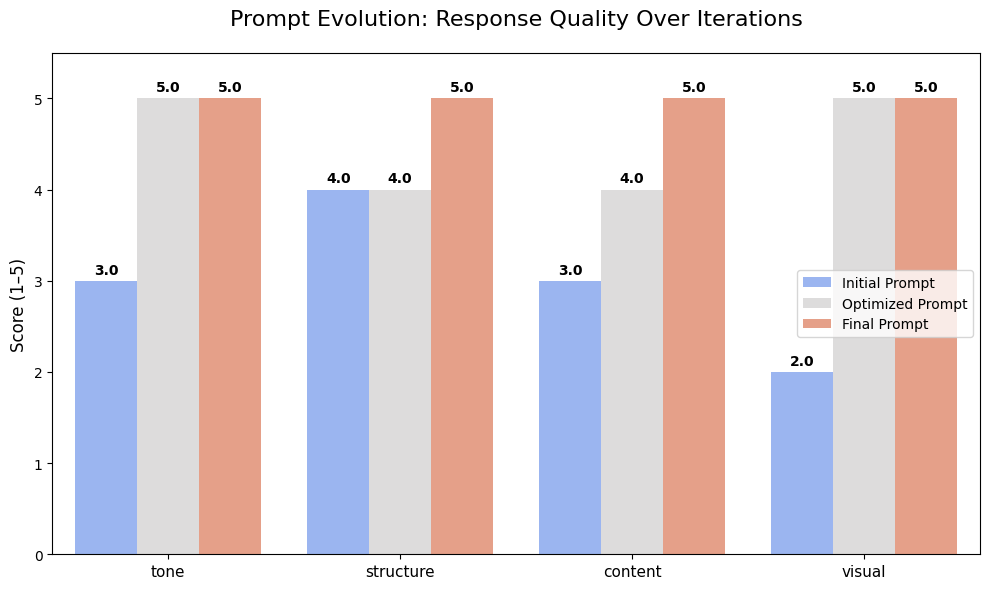


回答质量评分结果

Initial Prompt:
  tone: 3/5
  structure: 4/5
  content: 3/5
  visual: 2/5
  平均分: 3.00/5

Optimized Prompt:
  tone: 5/5
  structure: 4/5
  content: 4/5
  visual: 5/5
  平均分: 4.50/5

Final Prompt:
  tone: 5/5
  structure: 5/5
  content: 5/5
  visual: 5/5
  平均分: 5.00/5


In [29]:
from functions.grader_plot import plot_grader
import re


# 测试回答
bad_response = """
**TaskFriend** is a productivity assistant designed to help users efficiently manage their time.
It offers a range of features aimed at improving organization and time management:

- **Task Management**
- **Deadline Tracking**
- **Calendar Integration**
- **Planning & Summaries**

Overall, TaskFriend serves as a comprehensive organizational tool that helps users streamline 
their workflow, reduce missed deadlines, and maintain better control over their daily and 
long-term tasks.
"""


ok_response = """
👋 I'm **TaskFriend**, your personal productivity partner — nice to meet you! 🎉

I'm here to help you take control of your tasks, calendars, and notes — all in one smart, 
easy-to-use place. Let's make sure you're always working on what matters most, without the stress.  

Here's how I can help boost your productivity:

### 📅 Smart Scheduling  
Sync seamlessly with **Google Calendar** and **Outlook**, so your schedule is always up-to-date and at your fingertips.

### 📝 Flexible Task Entry  
Add tasks using:
- ✍️ Text
- 🗣️ Voice input
- 📧 Email integration  
Whatever fits your style best!

### 🔍 Automatic Prioritization  
Let me sort your to-dos by **due date** and **importance**, so you know exactly where to focus each day.

### 🧠 Daily & Weekly Planning Tools  
Start your day strong with a clear plan and get ahead on the week — I'll help you stay strategic and organized.

"""

# 重用之前的参考答案，完全匹配
perfect_response = reference_answer

# 详细评估回答质量
def grade_response_detailed(response_to_grade, reference=reference_answer):
    grader_prompt = f"""
    [角色] 你是一个提示词评估助手。
    [任务] 比较生成回答和参考答案。对改进要敏感。
    
    [指令] 每个指标的最高分是5分，最低是1分。

    [参考答案]
    {reference}

    [生成回答]
    {response_to_grade}

    [评分标准]
    - 语气 (tone): 友好、积极、对话式，像有帮助的朋友
    - 结构 (structure): 章节标题清晰，组织有序
    - 内容 (content): 包含所有关键功能和信息，无多余内容
    - 视觉 (visual): 使用表情符号、加粗、项目符号、间距等视觉元素

    [输出格式]
    只返回一个JSON对象：
    {{
      "tone": int,
      "structure": int,
      "content": int,
      "visual": int
    }}
    
    不要返回其他任何内容
    """
    try:
        raw_output = get_qwen_response(grader_prompt)

        # 静默提取JSON
        json_match = re.search(r'\{[^}]+\}', raw_output, re.DOTALL)
        if json_match:
            cleaned = json_match.group(0)
            result = json.loads(cleaned)
            # 将分数限制在1-5之间（后备措施）
            return {k: max(1, min(5, v)) for k, v in result.items()}
        else:
            return {"tone": 1, "structure": 1, "content": 1, "visual": 1}
    except Exception:
        return {"tone": 1, "structure": 1, "content": 1, "visual": 1}

# 📊 评估回答
scores = {
    "Initial Prompt": grade_response_detailed(bad_response),
    "Optimized Prompt": grade_response_detailed(ok_response),
    "Final Prompt": grade_response_detailed(perfect_response),
}

# 📈 绘制结果
plot_grader(
    scores,
    title="Prompt Evolution: Response Quality Over Iterations"
)

# 打印评分结果
print("\n" + "=" * 60)
print("回答质量评分结果")
print("=" * 60)
for prompt_name, score_dict in scores.items():
    print(f"\n{prompt_name}:")
    for dimension, score in score_dict.items():
        print(f"  {dimension}: {score}/5")
    avg_score = sum(score_dict.values()) / len(score_dict)
    print(f"  平均分: {avg_score:.2f}/5")



<b>1. 在 RAG 系统中，提示模板的主要目的是什么？</b>  

<ul>
    <li>A) 存储检索到的文档    </li>
    <li>B) 定义 AI 的人格特质    </li>
    <li>C) 指示 LLM 如何利用检索到的上下文回答查询    </li>
    <li>D) 取代系统提示</li>
</ul>

**查看答案 →**
</summary>

<div style="margin-top: 10px; padding: 15px; border: 1px solid #dee2e6; border-radius: 0 0 6px 6px;">

✅ **正确答案：** C) 指示 LLM 如何利用检索到的上下文回答查询  
📝 **说明**：
* 提示模板通过组合检索到的上下文和用户查询来组织传入 LLM 的输入，确保模型基于提供的数据作答，而不是依赖其既有知识。

</div>
</details>



## 要点回顾

* **什么是优质提示**
    * **系统提示就是 AI 的岗位说明书**——它界定角色、目标、受众、输出格式以及安全护栏。
    * **强提示可以防止偏航**——没有明确指令时，LLM 容易给出泛泛或跑题的回应。
    * **使用 R-G-C-A-F-G 框架**：
      - **Role（角色）**：AI 是谁（例如：“TaskFriend，一名效率助理”）
      - **Goal（目标）**：它要达成什么（例如：“帮助用户为任务排优先级”）
      - **Context（上下文）**：它可以使用哪些数据（例如：“通过任务列表的 RAG 检索”）
      - **Audience（受众）**：它在与谁对话（例如：“忙碌的职场人士”）
      - **Format（格式）**：它应该如何回应（例如：“使用项目符号，不要 Markdown”）
      - **Guardrails（护栏）**：它必须避免什么（例如：“禁止角色扮演，不发表个人意见”）
    * **提示模板的作用不同**——它们约束的是 LLM 如何利用**检索到的上下文**，而非它的身份。

<br>

* **用提示模板连接上下文与查询**
    * **提示模板是 RAG 的引擎**——它指示 LLM 如何利用检索文档作答。
    * **它们强化基于依据的输出**——类似“请基于上下文信息作答，不要引用既有知识”的语句能减少幻觉。
    * **它们标准化输入结构**——让提示更可预测、更易测试。
    * **优秀的模板包含以下要素**：
      - 在上下文与查询之间做清晰分隔（例如 `---`）
      - 指示忽略既有知识
      - 输出格式规则（例如 JSON、项目符号）
    * **它们并非万无一失**——用户查询仍可能覆盖模板指令，因此要明确设计边界。

<br>

* **构建更智能的提示模板**
    * **格式化提升清晰度**——使用 `# 标题`、`---`、`[方括号]` 和 `**加粗**` 引导模型。
    * **表情和视觉提示改善体验**——让输出更易读、更有吸引力。
    * **结构化输出至关重要**——提示模板可强制生成 JSON、表格或代码，便于生产系统解析。
    * **提示模板是开发者工具**——它们提升一致性，但无法完全阻止用户输入的影响。
    * **它们让 RAG 更可靠**——没有模板时，模型可能忽视上下文或退回到训练数据。

<br>

* **通用提示工程技巧**

    * **角色/人设提示**可改变语气与深度——例如“用 5 岁儿童听得懂的方式解释”与“以资深工程师的角度说明”。
    * **少样本示范**用示例教授格式和风格——哪怕只有一个示例，也能显著提升输出一致性。
    * **链式思考（CoT）**能提升推理能力——让模型“展示推理过程”往往能得到更好的答案。
    * **推理模型（如启用思考模式的 Qwen-plus）**更进一步——它们会在回答前自动生成内部推理。
    * **在推理模型上避免强制 CoT 提示**——可能造成循环思考；模型已在内部进行推理。

<br>

* **元提示与自动化评估**
    * **元提示**即“围绕提示本身进行提示”——利用 LLM 来审查并改进你的提示。
    * **它能加速迭代**——无需反复人工试错，而是自动化优化循环。
    * **差距分析**通过 LLM 评审将输出与参考答案对比。
    * **自动评分**使用评分量表（语气、结构、内容、视觉）量化质量。
    * **让提示也能 CI/CD**——像代码一样测试、打分和发布提示更新，确保大规模的一致质量。